In [38]:
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
import pandas.plotting as pdplt
import numpy as np
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from scipy.stats import zscore


# Constants

In [39]:
DATASET_PATH = "datasets/ruddit_with_text.csv"

UNUSED_COLUMNS = ["post_id", "comment_id", "url"]
SCORE_COLUMN = "offensiveness_score"
COMMENT_COLUMN = "txt"
OFFENSIVE_LABEL = "offensive"
NOT_OFFENSIVE_LABEL = "not_offensive"

STOPWORDS_LANGUAGE = "english"
MAX_DF = 0.75
Z_SCORE = 2

COUNT_VECTORIZER_PATH = "models/count_vectorizer.pickle"
TF_IDF_VECTORIZER_PATH = "models/tf_idf_vectorizer.pickle"

COUNT_SVM_MODEL_PATH = "models/count_svm_model.pickle"
TF_IDF_SVM_MODEL_PATH = "models/tf_idf_svm_model.pickle"
COUNT_NB_MODEL_PATH = "models/count_nb_model.pickle"
TF_IDF_NB_MODEL_PATH = "models/tf_idf_nb_model.pickle"

COUNT_SVM_TITLE = "COUNT - SVM"
TF_IDF_SVM_TITLE = "TF IDF - SVM"
COUNT_NB_TITLE = "COUNT - NB"
TF_IDF_NB_TITLE = "TF IDF - NB"

COUNT_SVM_STATS_PATH = "stats/count_svm_stats.png"
TF_IDF_SVM_STATS_PATH = "stats/tf_idf_svm_stats.png"
COUNT_NB_STATS_PATH = "stats/count_nb_stats.png"
TF_IDF_NB_STATS_PATH = "stats/tf_idf_nb_stats.png"


FIGURE_DPI = 240

SEED = 1928


# Data setup

In [40]:
dataset = pd.read_csv(DATASET_PATH)
dataset.head()


,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022
2,42g75o,cza23qx,[deleted],https://www.reddit.com/r/changemyview/comments...,0.167
3,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146
4,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083


##### Drops unused columns

In [41]:
dataset.drop(UNUSED_COLUMNS, axis="columns", inplace=True)


#### Drops deleted comments


In [42]:
dataset[COMMENT_COLUMN].replace("[deleted]", np.nan, inplace=True)
dataset.dropna(subset=[COMMENT_COLUMN], inplace=True)
dataset.head()


,txt,offensiveness_score
0,> The difference in average earnings between m...,-0.083
1,"The myth is that the ""gap"" is entirely based o...",-0.022
3,The assertion is that women get paid less for ...,-0.146
4,You said in the OP that's not what they're mea...,-0.083
5,>Men and women are not payed less for the same...,-0.042


#### Visualizations

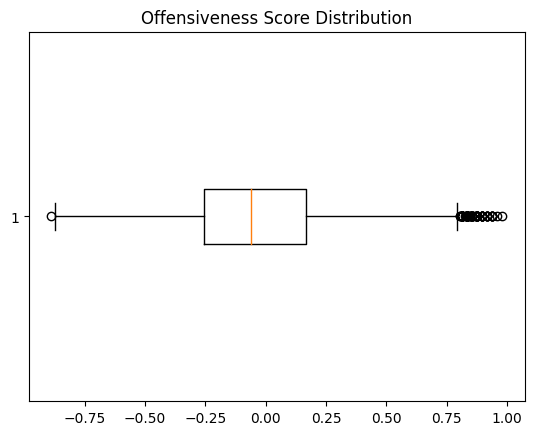

In [43]:
plt.boxplot(dataset[SCORE_COLUMN], vert=False)
_ = plt.title("Offensiveness Score Distribution")


# Lemmatization

In [44]:
from nltk import WordNetLemmatizer, word_tokenize, pos_tag


tag_mapping = {"NN": "n", "JJ": "a", "VB": "v", "RB": "r"}

def penn2morphy(penntag):
    try:
        return tag_mapping[penntag[:2]]
    except:
        return "n"

class CustomTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, sentence):
        tokens = word_tokenize(sentence)
        pos_tagged = pos_tag(tokens)
        return [
            self.lemmatizer.lemmatize(w, penn2morphy(t)) for (w, t) in pos_tagged
        ]


custom_tokenizer = CustomTokenizer()

sample_comment = dataset[COMMENT_COLUMN][3]
tokenized_comment = custom_tokenizer(sample_comment)

print(sample_comment)
print(tokenized_comment)


The assertion is that women get paid less for the *same* jobs, and that they get paid less *because* they are women. 
['The', 'assertion', 'be', 'that', 'woman', 'get', 'pay', 'less', 'for', 'the', '*', 'same', '*', 'job', ',', 'and', 'that', 'they', 'get', 'pay', 'less', '*', 'because', '*', 'they', 'be', 'woman', '.']


# Vectorization

In [45]:
x = dataset[COMMENT_COLUMN]
y = dataset[SCORE_COLUMN].map(
    lambda s: OFFENSIVE_LABEL if s > 0 else NOT_OFFENSIVE_LABEL
)


In [46]:
count_vectorizer = CountVectorizer(stop_words=STOPWORDS_LANGUAGE, tokenizer=custom_tokenizer, max_df=MAX_DF)
count_vectorizer.fit(dataset[COMMENT_COLUMN])


c:\arquivos\trabalho\desenvolvimento\ufc-pi-4\ai\venv\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\arquivos\trabalho\desenvolvimento\ufc-pi-4\ai\venv\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(


CountVectorizer(max_df=0.75, stop_words='english',
                tokenizer=<__main__.CustomTokenizer object at 0x000001D53E19FB20>)

In [47]:
tf_idf_vectorizer = TfidfVectorizer(stop_words=STOPWORDS_LANGUAGE, tokenizer=custom_tokenizer, max_df=MAX_DF)
tf_idf_vectorizer.fit(dataset[COMMENT_COLUMN])


TfidfVectorizer(max_df=0.75, stop_words='english',
                tokenizer=<__main__.CustomTokenizer object at 0x000001D53E19FB20>)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, random_state=SEED
)
count_x_train = count_vectorizer.transform(x_train)
count_x_test = count_vectorizer.transform(x_test)
tf_idf_x_train = tf_idf_vectorizer.transform(x_train)
tf_idf_x_test = tf_idf_vectorizer.transform(x_test)


# Training

In [49]:
count_svm_classifier = SVC(probability=True)
count_svm_classifier.fit(count_x_train, y_train)


SVC(probability=True)

In [50]:
tf_idf_svm_classifier = SVC(probability=True)
tf_idf_svm_classifier.fit(tf_idf_x_train, y_train)


SVC(probability=True)

In [51]:
count_nb_classifier = MultinomialNB()
count_nb_classifier.fit(count_x_train.toarray(), y_train)


MultinomialNB()

In [52]:
tf_idf_nb_classifier = GaussianNB()
tf_idf_nb_classifier.fit(tf_idf_x_train.toarray(), y_train)


GaussianNB()

# Reports

In [53]:
def generate_report_and_confusion(classifier, x_test, y_test):
    classes = classifier.classes_
    y_pred = classifier.predict(x_test)
    report = pd.DataFrame(
        classification_report(y_test, y_pred, output_dict=True)
    ).transpose()
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
    confusion.set_axis(classes, axis="rows", inplace=True)
    confusion.set_axis(classes, axis="columns", inplace=True)
    return [report, confusion]


In [54]:
def plot_report_and_confusion(report, confusion, title, fig_path):
    fig, main_axis = plt.subplots(1, 1)
    main_axis.axis("tight")
    main_axis.axis("off")
    [report_axis, confusion_axis] = fig.subplots(2, 1)
    report_axis.axis("tight")
    report_axis.axis("off")
    pdplt.table(report_axis, report, loc="center")
    report_axis.set_title(title)
    confusion_axis.axis("tight")
    confusion_axis.axis("off")
    pdplt.table(confusion_axis, confusion, loc="center")
    confusion_axis.set_title("Matriz de Confusão")
    fig.tight_layout()
    fig.savefig(fig_path, bbox_inches="tight", dpi=FIGURE_DPI)


In [55]:
def generate_stats(classifier, x_test, y_test, title, fig_path):
    [report, confusion] = generate_report_and_confusion(classifier, x_test, y_test)
    plot_report_and_confusion(report, confusion, title, fig_path)


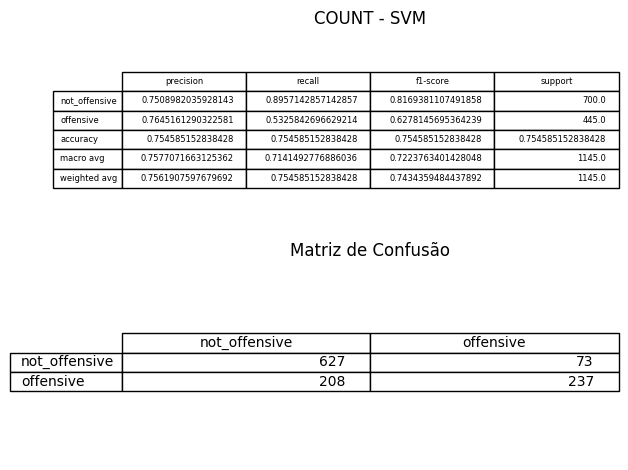

In [56]:
generate_stats(
    count_svm_classifier, count_x_test, y_test, COUNT_SVM_TITLE, COUNT_SVM_STATS_PATH
)


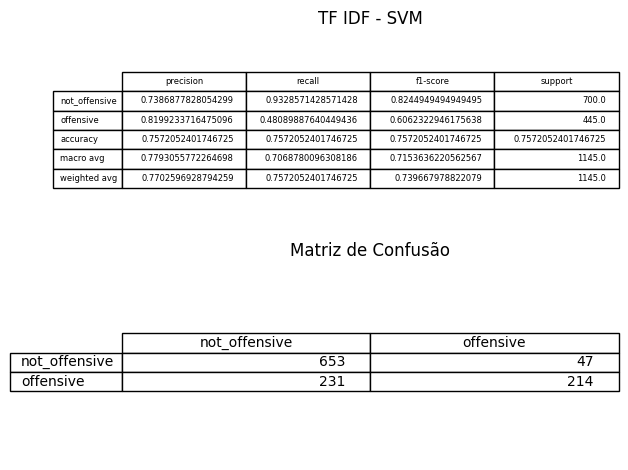

In [57]:
generate_stats(
    tf_idf_svm_classifier,
    tf_idf_x_test,
    y_test,
    TF_IDF_SVM_TITLE,
    TF_IDF_SVM_STATS_PATH,
)


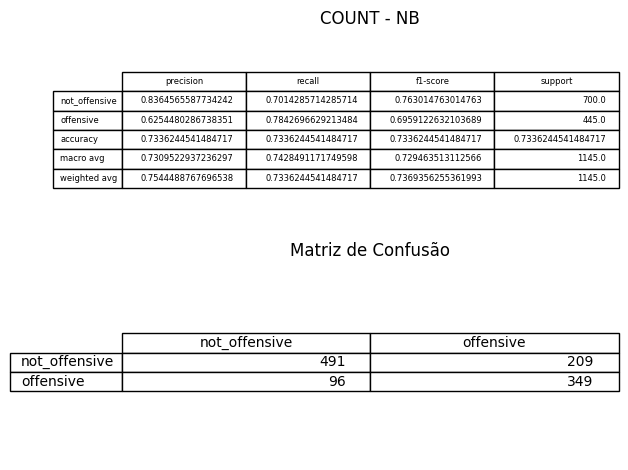

In [58]:
generate_stats(
    count_nb_classifier, count_x_test, y_test, COUNT_NB_TITLE, COUNT_NB_STATS_PATH
)


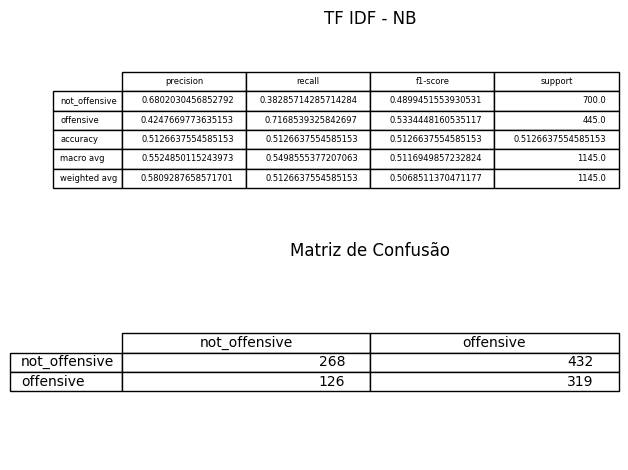

In [59]:
generate_stats(
    tf_idf_nb_classifier,
    tf_idf_x_test.toarray(),
    y_test,
    TF_IDF_NB_TITLE,
    TF_IDF_NB_STATS_PATH,
)


# Saves model

In [60]:
def pickle_to_file(object, path):
    with open(path, "wb") as file:
        pk.dump(object, file)


In [61]:
pickle_to_file(count_vectorizer, COUNT_VECTORIZER_PATH)
pickle_to_file(tf_idf_vectorizer, TF_IDF_VECTORIZER_PATH)

pickle_to_file(count_svm_classifier, COUNT_SVM_MODEL_PATH)
pickle_to_file(tf_idf_svm_classifier, TF_IDF_SVM_MODEL_PATH)
pickle_to_file(count_nb_classifier, COUNT_NB_MODEL_PATH)
pickle_to_file(tf_idf_nb_classifier, TF_IDF_NB_MODEL_PATH)


# Playground

In [62]:
comment = "So well after a funny night of games, me and my friends say bye"
vectorized = tf_idf_vectorizer.transform([comment])
prediction = tf_idf_svm_classifier.predict_proba(vectorized)
print(f"offensiveness: {prediction[0]}")


offensiveness: [0.90200049 0.09799951]
